In [1]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.stats import gaussian_kde
import seaborn as sns
import SimpleITK as sitk
import glob
import os
import re
from collections import defaultdict
import nibabel as nb

In [2]:
import warnings
warnings.filterwarnings("ignore")

*this part was edited on Jan 18, 2022 to obtain result for CAL010 (decide whether or not to recollect data)

# Functions

In [3]:
#takes as input raw minc filenames, they should be ordered from lowest to greatest flip angle
def voxel_wise_lr(mtr_map_masked_concat_dict, FA_dict, mask_indices_dict):
    
    ##############################################  normalize the FA dict #######################
    FA_norm_cent_dict = {}
    
    #the first key in the dictionary contains each sub - find max FA for each sub
    for sub in FA_dict.keys():
        maxFA_per_sub = max(FA_dict[sub])
        #normalize by dividing by max flip angle, and center at 0 by subtracting 1
        FA_norm_cent_dict[sub] = (FA_dict[sub].reshape(-1,1)/maxFA_per_sub)-1

    ########################################### linear regression ###############################
    #create an empty dict to hold the slopes mtrix for each sub
    slopes_dict = {}
    
    #perform the linear regression by looping over all voxels in mask- is there no way to do this in parallel?
    #for each voxel, add the slope from the linear regression to the slopes array
    for sub in FA_dict.keys():
        #extract info from mask
        original_3d_shape = mask_indices_dict[sub].shape
        numvox_in_mask = mtr_map_masked_concat_dict[sub].shape[0]
        slopes = np.zeros((numvox_in_mask,))
        
        for i in range(0, numvox_in_mask):
            mtr_norm_across_FA = np.array([])
            regr_obj = linear_model.LinearRegression(fit_intercept = False)
            regr_fit = regr_obj.fit(FA_norm_cent_dict[sub], mtr_map_masked_concat_dict[sub][i,:])
            slopes[i] = regr_fit.coef_
            
        #recover the 3D matrix format using mask information
        slopes_matrix = np.zeros(original_3d_shape)
        slopes_matrix[mask_indices_dict[sub]] = slopes
        slopes_dict[sub] = slopes_matrix
        slopes = np.zeros((numvox_in_mask,))
    
    return slopes_dict, FA_norm_cent_dict

# Load data

In [4]:
#these maps were created on jan 18 with cal010 data because it was the only one with consistent RG. B1 maps were weird though.
#they are from the cic folder /data/scratch/mila/2021_mtr/part2_derive_B1_correction/2_derivatives/mtr_maps/mtr_maps_denoised_normalized_masked
mtr_map_files = glob.glob("../files_for_code/b1_mtr_relationship_exvivo/*mtr_map*")
mask_files = glob.glob("../files_for_code/b1_mtr_relationship_exvivo/*mask*")

# Preprocess and extract info

In [6]:
#create dictionaries that can have two keys (one for sub and one for FA)
mtr_map_dict = defaultdict(dict)
mtr_map_masked_concat_dict = {}
mtr_arrays_to_fill_dict = {}
FA_dict = {}
mask_indices_dict = {}
numvox_dict = {}

#process all the masks (one per sub)
for file in range (0,len(mask_files)):
    #extract subject ID from name
    file_name = os.path.basename(mask_files[file])
    sub = re.search('sub-(.*)_acq', file_name).group(1)
    
    #convert the mncs to arrays
    mask_arr = sitk.GetArrayFromImage(sitk.ReadImage(mask_files[file]))
    vol_indices = mask_arr.astype(bool)
    numvox = mask_arr[vol_indices].shape[0]

    #store the information (the mask array, the boolean indices and the num of voxels)
    mask_indices_dict[sub] = vol_indices
    numvox_dict[sub] = numvox
    
    #also, store empty arrays for the concatenated mtr maps (since there is one per sub) in a dict
    mtr_arrays_to_fill_dict[sub] = np.empty((numvox, 0))

#create arrays that will be filled for each FA
FA_array_per_sub = np.array([])
prev_sub = 'HARA06'

#process all the mtr maps (multiple per sub)
for file in range (0,len(mtr_map_files)):
    
    #extract subject ID and FA from name
    file_name = os.path.basename(mtr_map_files[file])
    sub = re.search('sub-(.*)_acq', file_name).group(1)
    FA = re.search('flip-(.*)_MTw', file_name).group(1)
    FA_to_store = int(FA)
    
    #convert the mncs to arrays
    mtr_map_arr = sitk.GetArrayFromImage(sitk.ReadImage(mtr_map_files[file]))
    
    #process mincs by masking and centering them
    mtr_map_arr_masked_centered = np.expand_dims(mtr_map_arr[mask_indices_dict[sub]], axis = 1) - 1
    mtr_map_dict[sub][FA] = mtr_map_arr
    
    #concatenate the flat, masked mtr map to the previous map along the second dimension (if the sub is the same)
    if (prev_sub == sub) | (file == 0):
        mtr_arrays_to_fill_dict[sub] = np.append(mtr_arrays_to_fill_dict[sub], mtr_map_arr_masked_centered, axis = 1)
        FA_array_per_sub = np.append(FA_array_per_sub, FA_to_store)
        
    if (prev_sub != sub) | (file == (len(mtr_map_files)-1)):
        #if a new sub, then add the final mtr_map_concat to df, and reinitialize a new one
        mtr_map_masked_concat_dict[prev_sub] = mtr_arrays_to_fill_dict[prev_sub]
        FA_dict[prev_sub] = FA_array_per_sub
        FA_array_per_sub = FA_to_store
    
    prev_sub = sub

In [7]:
FA_dict

{'HARA06': array([1020.,  780.,  810.,  840.,  870.,  900.,  930.,  960.,  990.])}

In [11]:
mtr_map_masked_concat_dict['HARA06'].shape

(34439, 9)

In [12]:
numvox_dict

{'HARA06': 34439}

# Run the voxelwise linear regression

In [13]:
voxel_wise_lr_slopes_matrix, FA_norm_cent_dict = voxel_wise_lr(mtr_map_masked_concat_dict, FA_dict, mask_indices_dict)

<function matplotlib.pyplot.show(close=None, block=None)>

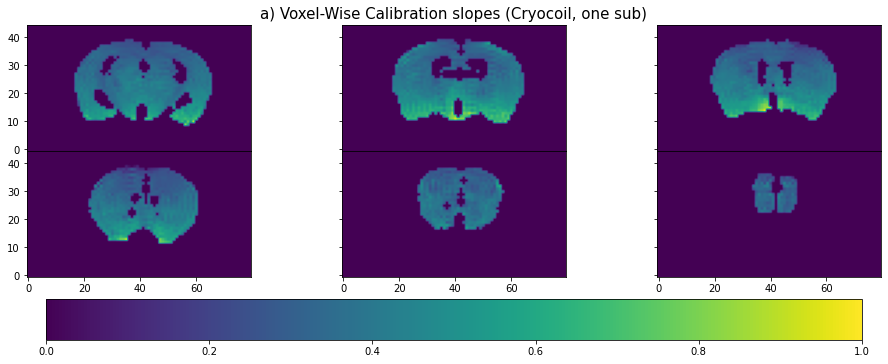

In [15]:
#plot the results
fig, axs = plt.subplots(2, 3, figsize=(16,5), sharey = True, sharex = True)
vmax_val = 1
pic1_d_e = axs[0,0].imshow(voxel_wise_lr_slopes_matrix['HARA06'][:, 40, :], vmin=0, vmax=vmax_val, origin = 'lower')
pic1_d_e = axs[0,1].imshow(voxel_wise_lr_slopes_matrix['HARA06'][:, 45, :], vmin=0, vmax=vmax_val, origin = 'lower')
pic1_d_e = axs[0,2].imshow(voxel_wise_lr_slopes_matrix['HARA06'][:, 50, :], vmin=0, vmax=vmax_val, origin = 'lower')

pic1_d_e = axs[1,0].imshow(voxel_wise_lr_slopes_matrix['HARA06'][:, 55, :], vmin=0, vmax=vmax_val, origin = 'lower')
pic1_d_e = axs[1,1].imshow(voxel_wise_lr_slopes_matrix['HARA06'][:, 60, :], vmin=0, vmax=vmax_val, origin = 'lower')
pic1_d_e = axs[1,2].imshow(voxel_wise_lr_slopes_matrix['HARA06'][:, 65, :], vmin=0, vmax=vmax_val, origin = 'lower')


fig.colorbar(pic1_d_e, ax=axs, orientation='horizontal')
plt.subplots_adjust(bottom = 0.3, top = 1, hspace=0.001)
axs[0,1].set_title('a) Voxel-Wise Calibration slopes (Cryocoil, one sub)', fontsize = 15)
plt.show

# Run the overall linear regression

In [16]:
FA_norm_cent_dict

{'HARA06': array([[ 0.        ],
        [-0.23529412],
        [-0.20588235],
        [-0.17647059],
        [-0.14705882],
        [-0.11764706],
        [-0.08823529],
        [-0.05882353],
        [-0.02941176]])}

## Version 1: regress one line over all MTR values per FA

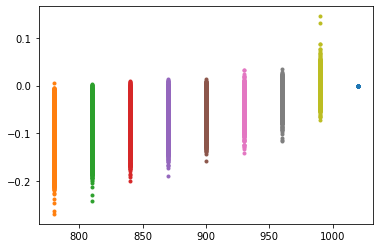

In [19]:
#I SHOULD MAKE THIS INTO A BOX PLOT
#plot all mtr values inside mask, at each FA - these go negative because they are centered
plt.figure()
plt.plot(np.repeat(FA_dict['HARA06'][0],numvox_dict['HARA06']), mtr_map_masked_concat_dict['HARA06'][:,0], '.')
plt.plot(np.repeat(FA_dict['HARA06'][1],numvox_dict['HARA06']), mtr_map_masked_concat_dict['HARA06'][:,1], '.')
plt.plot(np.repeat(FA_dict['HARA06'][2],numvox_dict['HARA06']), mtr_map_masked_concat_dict['HARA06'][:,2], '.')
plt.plot(np.repeat(FA_dict['HARA06'][3],numvox_dict['HARA06']), mtr_map_masked_concat_dict['HARA06'][:,3], '.')
plt.plot(np.repeat(FA_dict['HARA06'][4],numvox_dict['HARA06']), mtr_map_masked_concat_dict['HARA06'][:,4], '.')
plt.plot(np.repeat(FA_dict['HARA06'][5],numvox_dict['HARA06']), mtr_map_masked_concat_dict['HARA06'][:,5], '.')
plt.plot(np.repeat(FA_dict['HARA06'][6],numvox_dict['HARA06']), mtr_map_masked_concat_dict['HARA06'][:,6], '.')
plt.plot(np.repeat(FA_dict['HARA06'][7],numvox_dict['HARA06']), mtr_map_masked_concat_dict['HARA06'][:,7], '.')
plt.plot(np.repeat(FA_dict['HARA06'][8],numvox_dict['HARA06']), mtr_map_masked_concat_dict['HARA06'][:,8], '.')
plt.show()

## Version 2: Regress one line over the mean MTR per FA

In [21]:
#perform the linear regression on the centered MTR and FA values
regr_obj = linear_model.LinearRegression(fit_intercept = False)
regr_fit = regr_obj.fit(FA_norm_cent_dict['HARA06'], np.mean(mtr_map_masked_concat_dict['HARA06'], axis = 0))
slope_across_means = regr_fit.coef_
slope_across_means

array([0.39521599])

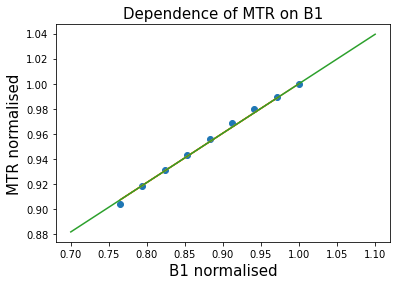

In [49]:
#plot all average mtr value inside mask, at each FA - these go negative because they are centered
plt.figure()
plt.plot(FA_norm_cent_dict['HARA06']+1,np.mean(mtr_map_masked_concat_dict['HARA06']+1, axis = 0), 'o')
plt.plot(FA_norm_cent_dict['HARA06']+1, slope_across_means*(FA_norm_cent_dict['HARA06'])+1)
plt.plot(np.arange(0.7,1.1,0.1), slope_across_means*(np.arange(0.7,1.1,0.1)) + (1-slope_across_means))
plt.ylabel('MTR normalised', fontsize = 15)
plt.xlabel('B1 normalised', fontsize = 15)
plt.title('Dependence of MTR on B1', fontsize = 15)
plt.show()

In [37]:
FA_norm_cent_dict['HARA06']+1

array([[1.        ],
       [0.76470588],
       [0.79411765],
       [0.82352941],
       [0.85294118],
       [0.88235294],
       [0.91176471],
       [0.94117647],
       [0.97058824]])

In [50]:
(1-slope_across_means)

array([0.60478401])